# Dataset NearMiss e não normalizado

In [ ]:
# Importações de Bibliotecas
import pandas as pd
import numpy as np
import sklearn
import math

# Datas
from datetime import datetime, timedelta

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Balanceamento
from imblearn.under_sampling import NearMiss
# from imblearn.over_sampling import SMOTE

# Divisão de dados
from sklearn.model_selection import train_test_split

# Classificador
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# Métricas
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay, f1_score

In [ ]:
# Local do Dataset
url = "https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2022/INFLUD22-23-01-2023.csv"

In [ ]:
# Carregando Dataset
data = pd.read_csv(url, sep=';', na_filter = True)
print(f"{len(data)} linhas lidas")

<ipython-input-101-5503c4e8948e>:2: DtypeWarning: Columns (15,59,61,62,63,91,93,105,107,120,122,143) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url, sep=';', na_filter = True)


561242 linhas lidas


In [ ]:
# Formato do Dataset
data.shape

(561242, 166)

# Delimitando Dataset

Este dataset é composto por notificações realacionadas as Síndromes Respiratórias Agudas Graves SRAGs no Brasil no ano de 2022

In [ ]:
# Delimitando apenas para notificações de Covid-19
data = data[data['CLASSI_FIN'] == 5]
data.shape

(235891, 166)

In [ ]:
# Deixando apenas com notificações do Paraná
data = data[data['SG_UF_NOT'] == 'PR']
data.shape

(19002, 166)

In [ ]:
# Removendo instâncias com 3 e 9, pois equivalem, respectivamente a "óbito por outras causas" e "ignorado"
data = data[(data['EVOLUCAO'] == 1) | (data['EVOLUCAO'] == 2)]

# Atualizando o target 'EVOLUCAO' para 0 e 1
data['EVOLUCAO'] = data['EVOLUCAO'].map({1: 0, 2: 1})
data.shape

(17699, 166)

# Eliminação Manual de Atributos

In [ ]:
# Dados redundantes após a delimitação
data.drop(['CLASSI_FIN', 'SG_UF_NOT'], axis=1, inplace=True)
data.shape

(17699, 164)

In [ ]:
# Retirando atributos categorizadas como Campos Internos
data.drop(["SEM_NOT", "SEM_PRI", "ID_REGIONA", "CO_REGIONA", "ID_RG_RESI",
           "CO_RG_RESI", "FNT_IN_COV", "ID_RG_INTE", "CO_RG_INTE", "DT_DIGITA"],
          axis=1, inplace=True)
data.shape

(17699, 154)

In [ ]:
# Atributos Relacionados a localização
data.drop(["ID_MUNICIP", "CO_MUN_NOT", "ID_UNIDADE", "CO_UNI_NOT", "ID_PAIS",
           "CO_PAIS", "SG_UF", "ID_MN_RESI", "CO_MUN_RES", "CS_ZONA", "ESTRANG",
           "SG_UF_INTE", "ID_MN_INTE", "CO_MU_INTE"], axis=1, inplace=True)
data.shape

(17699, 140)

In [ ]:
# Redundância na idade
data.drop(["DT_NASC", "TP_IDADE", "COD_IDADE"], axis=1, inplace=True)
data.shape

(17699, 137)

In [ ]:
# Dados relacionados a informações da vacina
data.drop(["LOTE_1_COV", "LOTE_2_COV","LOTE_REF", "FAB_COV_1", "FAB_COV_2",
           "FAB_COVREF", "LAB_PR_COV"], axis=1, inplace=True)
data.shape

(17699, 130)

In [ ]:
# Atributos que não constam no dicionário de dados
data.drop(["HISTO_VGM", "PCR_SARS2"], axis=1, inplace=True)
data.shape

(17699, 128)

In [ ]:
# datas administrativas
data.drop(["DT_ENCERRA", "DT_COLETA"], axis=1, inplace=True)
data.shape

(17699, 126)

In [ ]:
# Outras colunas
data.drop(["AVE_SUINO", "CS_RACA"], axis=1, inplace=True)
data.shape

(17699, 124)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17699 entries, 32 to 561154
Columns: 124 entries, DT_NOTIFIC to DOSE_REF
dtypes: float64(81), int64(4), object(39)
memory usage: 16.9+ MB


# Tratamento de Valores Ignorados

In [ ]:
# Alteração dos valores 9 (ignorados) para NaN
for column in data:
  if ((data[column].dtypes != 'object') and
   (column != 'NU_IDADE_N')) or (column == 'CS_SEXO'):
    data[column] = data[column].apply(lambda x: np.nan if x == 9 else x)

# Filtro 50%

Filtro de 50% em linhas e colunas, prezando pela qualidade e não quantidade de dados.

In [ ]:
# Limiar de procentagem de dados faltantes
threshold = 0.5

# Calcula a porcentagem de dados faltantes em cada coluna
porcentagem_nan = data.isnull().sum() / len(data)

# Filtra as colunas que têm mais de 50% dos dados faltantes
colunas_remocao = porcentagem_nan[porcentagem_nan > threshold].index

# Remoção das colunas
data = data.drop(colunas_remocao, axis=1)

print(f'{len(colunas_remocao)} colunas foram removidas')
print(data.shape)

82 colunas foram removidas
(17699, 42)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17699 entries, 32 to 561154
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DT_NOTIFIC  17699 non-null  object 
 1   DT_SIN_PRI  17699 non-null  object 
 2   CS_SEXO     17699 non-null  object 
 3   NU_IDADE_N  17699 non-null  int64  
 4   CS_GESTANT  17444 non-null  float64
 5   NOSOCOMIAL  16050 non-null  float64
 6   FEBRE       14589 non-null  float64
 7   TOSSE       15203 non-null  float64
 8   GARGANTA    13245 non-null  float64
 9   DISPNEIA    14895 non-null  float64
 10  DESC_RESP   14042 non-null  float64
 11  SATURACAO   14704 non-null  float64
 12  DIARREIA    12727 non-null  float64
 13  VOMITO      12720 non-null  float64
 14  OUTRO_SIN   12936 non-null  float64
 15  FATOR_RISC  17699 non-null  int64  
 16  CARDIOPATI  9805 non-null   float64
 17  DIABETES    9129 non-null   float64
 18  OUT_MORBI   9683 non-null   float64
 19  ANTIVIRAL   15008 non-n

In [ ]:
# Reinicia o index de cada instância
data = data.reset_index(drop=True)

In [ ]:
# Limiar de procentagem de dados faltantes
threshold = 0.5

# Calcula a porcentagem de dados faltantes em cada linha
porcentagem_nan = data.isnull().sum(axis=1) / data.shape[1]

# Filtra as linhas que têm mais de 50% dos dados faltantes
linhas_remocao = porcentagem_nan[porcentagem_nan > threshold].index

# Remove as linhas
data = data.drop(linhas_remocao, axis=0)

print(f'{len(linhas_remocao)} linhas foram removidas')
print(data.shape)

267 linhas foram removidas
(17432, 42)


In [ ]:
# Reinicia o index de cada instância
data = data.reset_index(drop=True)

# Preenchimento de valores NaN do tipo float

In [ ]:
# Dados faltantes
faltantes = data.isnull().sum()
faltantes

DT_NOTIFIC       0
DT_SIN_PRI       0
CS_SEXO          0
NU_IDADE_N       0
CS_GESTANT     249
NOSOCOMIAL    1582
FEBRE         2871
TOSSE         2271
GARGANTA      4203
DISPNEIA      2564
DESC_RESP     3406
SATURACAO     2756
DIARREIA      4712
VOMITO        4714
OUTRO_SIN     4522
FATOR_RISC       0
CARDIOPATI    7639
DIABETES      8314
OUT_MORBI     7762
ANTIVIRAL     2580
HOSPITAL        73
DT_INTERNA     486
UTI            777
SUPORT_VEN     607
RAIOX_RES     6310
AMOSTRA        360
TP_AMOSTRA     809
PCR_RESUL      722
DT_PCR        6336
POS_PCROUT    7362
CRITERIO       331
EVOLUCAO         0
DT_EVOLUCA     137
DOR_ABD       4883
FADIGA        4567
PERD_OLFT     5043
PERD_PALA     5075
TOMO_RES      7470
RES_AN         523
VACINA_COV     284
DOSE_1_COV    4601
DOSE_2_COV    5264
dtype: int64

Todos os NaN serão substituidos pelo valor da mediana daquele atributo.

In [ ]:
# Seleciona as colunas do tipo float
colunas_float = data.select_dtypes(include='float64').columns

# Substitui os valores NaN pela mediana de cada coluna
data[colunas_float] = data[colunas_float].fillna(data[colunas_float].median().iloc[0])

In [ ]:
# Dados faltantes
faltantes = data.isnull().sum()
faltantes

DT_NOTIFIC       0
DT_SIN_PRI       0
CS_SEXO          0
NU_IDADE_N       0
CS_GESTANT       0
NOSOCOMIAL       0
FEBRE            0
TOSSE            0
GARGANTA         0
DISPNEIA         0
DESC_RESP        0
SATURACAO        0
DIARREIA         0
VOMITO           0
OUTRO_SIN        0
FATOR_RISC       0
CARDIOPATI       0
DIABETES         0
OUT_MORBI        0
ANTIVIRAL        0
HOSPITAL         0
DT_INTERNA     486
UTI              0
SUPORT_VEN       0
RAIOX_RES        0
AMOSTRA          0
TP_AMOSTRA       0
PCR_RESUL        0
DT_PCR        6336
POS_PCROUT       0
CRITERIO         0
EVOLUCAO         0
DT_EVOLUCA     137
DOR_ABD          0
FADIGA           0
PERD_OLFT        0
PERD_PALA        0
TOMO_RES         0
RES_AN           0
VACINA_COV       0
DOSE_1_COV    4601
DOSE_2_COV    5264
dtype: int64

# Tratando Datas

Criação de uma coluna chamada "QTD_DIAS" que é resultante da relação entre data da Notificação do paciente até a Evolução.

*DT_NOTIFIC com DT_EVOLUCA*

In [ ]:
# QTD_DIAS armazena a quantidade de dias desde a notificação até a evolução.
data['QTD_DIAS'] = ''

In [ ]:
# Calcula o intervalo de dias entre duas datas
def calcular_qtd_dias(row):
  if pd.isna(row['DT_EVOLUCA']):
    return np.nan
  else:
    data1 = datetime.strptime(row['DT_NOTIFIC'], '%d/%m/%Y')
    data2 = datetime.strptime(row['DT_EVOLUCA'], '%d/%m/%Y')
    dias = abs((data2 - data1).days)
    return dias

# Chama a função e atribui o resultado à coluna 'QTD_DIAS'
data['QTD_DIAS'] = data.apply(calcular_qtd_dias, axis=1)

In [ ]:
data[['DT_NOTIFIC', 'DT_EVOLUCA', 'QTD_DIAS']]

,DT_NOTIFIC,DT_EVOLUCA,QTD_DIAS
0,05/01/2022,06/01/2022,1.0
1,07/01/2022,25/01/2022,18.0
2,10/01/2022,13/01/2022,3.0
3,19/01/2022,07/02/2022,19.0
4,10/01/2022,13/01/2022,3.0
...,...,...,...
17427,29/06/2022,29/06/2022,0.0
17428,09/08/2022,12/08/2022,3.0
17429,30/08/2022,01/09/2022,2.0
17430,10/11/2022,17/11/2022,7.0


In [ ]:
data['QTD_DIAS'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17432 entries, 0 to 17431
Series name: QTD_DIAS
Non-Null Count  Dtype  
--------------  -----  
17295 non-null  float64
dtypes: float64(1)
memory usage: 136.3 KB


In [ ]:
# Calcula a mediana de 'QTD_DIAS'
data['QTD_DIAS'].median()

5.0

In [ ]:
# Conta os valores NaN em 'QTD_DIAS'
data['QTD_DIAS'].isnull().sum()

137

In [ ]:
# Preenche valores NaN com a mediana
data['QTD_DIAS'].fillna(data['QTD_DIAS'].median(), inplace=True)

In [ ]:
# Converte o tipo de dados de float para int
data['QTD_DIAS'] = data['QTD_DIAS'].astype(int)

In [ ]:
data['QTD_DIAS'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17432 entries, 0 to 17431
Series name: QTD_DIAS
Non-Null Count  Dtype
--------------  -----
17432 non-null  int64
dtypes: int64(1)
memory usage: 136.3 KB


Criação de uma coluna chamada "DIAS_INTERNA" que representa a quantidade de dias que um paciente ficou hospitalizado.

*DT_INTERNA com DT_EVOLUCA*

In [ ]:
# DIAS_INTERNA armazena a quantidade de dias internado desde a data de internação
# até a evolução.
data['DIAS_INTERNA'] = ''

In [ ]:
# Calcula o intervalo de dias entre duas datas
def calc_dias_interna(row):
  if row['HOSPITAL'] == 1:
    if pd.isna(row['DT_INTERNA']) or pd.isna(row['DT_EVOLUCA']):
      return np.nan
    else:
      data1 = datetime.strptime(row['DT_INTERNA'], '%d/%m/%Y')
      data2 = datetime.strptime(row['DT_EVOLUCA'], '%d/%m/%Y')
      return abs((data2 - data1).days)
  else:
    return 0

# Chama a função e atribui o resultado à coluna 'DIAS_INTERNA'
data['DIAS_INTERNA'] = data.apply(calc_dias_interna, axis=1)

In [ ]:
data[['DT_INTERNA', 'DT_EVOLUCA', 'DIAS_INTERNA']]

,DT_INTERNA,DT_EVOLUCA,DIAS_INTERNA
0,05/01/2022,06/01/2022,1.0
1,07/01/2022,25/01/2022,18.0
2,11/01/2022,13/01/2022,2.0
3,19/01/2022,07/02/2022,19.0
4,10/01/2022,13/01/2022,3.0
...,...,...,...
17427,28/06/2022,29/06/2022,1.0
17428,09/08/2022,12/08/2022,3.0
17429,30/08/2022,01/09/2022,2.0
17430,09/11/2022,17/11/2022,8.0


In [ ]:
data['DIAS_INTERNA'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17432 entries, 0 to 17431
Series name: DIAS_INTERNA
Non-Null Count  Dtype  
--------------  -----  
17255 non-null  float64
dtypes: float64(1)
memory usage: 136.3 KB


In [ ]:
# Calcula a mediana de 'DIAS_INTERNA'
data['DIAS_INTERNA'].median()

5.0

In [ ]:
# Conta os valores NaN em 'DIAS_INTERNA'
data['DIAS_INTERNA'].isnull().sum()

177

In [ ]:
# Preenche valores NaN com a mediana
data['DIAS_INTERNA'].fillna(data['DIAS_INTERNA'].median(), inplace=True)

In [ ]:
# Converte o tipo de dados de float para int
data['DIAS_INTERNA'] = data['DIAS_INTERNA'].astype(int)

In [ ]:
data['DIAS_INTERNA'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17432 entries, 0 to 17431
Series name: DIAS_INTERNA
Non-Null Count  Dtype
--------------  -----
17432 non-null  int64
dtypes: int64(1)
memory usage: 136.3 KB


In [ ]:
data[['DT_INTERNA', 'DT_EVOLUCA', 'DT_SIN_PRI', 'DT_NOTIFIC', 'DT_PCR']]

,DT_INTERNA,DT_EVOLUCA,DT_SIN_PRI,DT_NOTIFIC,DT_PCR
0,05/01/2022,06/01/2022,03/01/2022,05/01/2022,09/01/2022
1,07/01/2022,25/01/2022,05/01/2022,07/01/2022,NaN
2,11/01/2022,13/01/2022,07/01/2022,10/01/2022,13/01/2022
3,19/01/2022,07/02/2022,06/01/2022,19/01/2022,21/01/2022
4,10/01/2022,13/01/2022,10/01/2022,10/01/2022,13/01/2022
...,...,...,...,...,...
17427,28/06/2022,29/06/2022,26/06/2022,29/06/2022,NaN
17428,09/08/2022,12/08/2022,06/08/2022,09/08/2022,15/08/2022
17429,30/08/2022,01/09/2022,27/08/2022,30/08/2022,02/09/2022
17430,09/11/2022,17/11/2022,03/11/2022,10/11/2022,17/11/2022


Criação de uma coluna "SINT_ATE_NOTIF" que representa a quantidade de dias entre os primeiros sintomas do paciente até a notificação.

*DT_SIN_PRI com DT_NOTIFIC*

In [ ]:
data['SINT_ATE_NOTIF'] = ''

In [ ]:
# Calcula o intervalo de dias entre duas datas
def calc_dias_sintomas(row):
  data1 = datetime.strptime(row['DT_SIN_PRI'], '%d/%m/%Y')
  data2 = datetime.strptime(row['DT_NOTIFIC'], '%d/%m/%Y')
  return abs((data2 - data1).days)

# Chama a função e atribui o resultado à coluna 'SINT_ATE_NOTIF'
data['SINT_ATE_NOTIF'] = data.apply(calc_dias_sintomas, axis=1)

In [ ]:
data[['DT_SIN_PRI', 'DT_NOTIFIC', 'SINT_ATE_NOTIF']]

,DT_SIN_PRI,DT_NOTIFIC,SINT_ATE_NOTIF
0,03/01/2022,05/01/2022,2
1,05/01/2022,07/01/2022,2
2,07/01/2022,10/01/2022,3
3,06/01/2022,19/01/2022,13
4,10/01/2022,10/01/2022,0
...,...,...,...
17427,26/06/2022,29/06/2022,3
17428,06/08/2022,09/08/2022,3
17429,27/08/2022,30/08/2022,3
17430,03/11/2022,10/11/2022,7


In [ ]:
data['SINT_ATE_NOTIF'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17432 entries, 0 to 17431
Series name: SINT_ATE_NOTIF
Non-Null Count  Dtype
--------------  -----
17432 non-null  int64
dtypes: int64(1)
memory usage: 136.3 KB


Criação da coluna "PCR_EVOLUCAO" que calcula a diferença de dias entre a data do PCR e a data da evolução.

*DT_PCR com DT_EVOLUCA*

In [ ]:
data['PCR_EVOLUCAO'] = ''

In [ ]:
# Calcula a diferença de dias entre duas datas
def calc_pcr_evo(row):
  if row['PCR_RESUL'] != 4:
    if pd.isna(row['DT_PCR']) or pd.isna(row['DT_EVOLUCA']):
      return np.nan
    else:
      data1 = datetime.strptime(row['DT_PCR'], '%d/%m/%Y')
      data2 = datetime.strptime(row['DT_EVOLUCA'], '%d/%m/%Y')
      return abs((data2 - data1).days)
  else:
    return 0

# Chama a função e atribui o resultado à coluna 'PCR_EVOLUCAO'
data['PCR_EVOLUCAO'] = data.apply(calc_pcr_evo, axis=1)

In [ ]:
data[['DT_PCR', 'DT_EVOLUCA', 'PCR_EVOLUCAO']]

,DT_PCR,DT_EVOLUCA,PCR_EVOLUCAO
0,09/01/2022,06/01/2022,3.0
1,NaN,25/01/2022,0.0
2,13/01/2022,13/01/2022,0.0
3,21/01/2022,07/02/2022,17.0
4,13/01/2022,13/01/2022,0.0
...,...,...,...
17427,NaN,29/06/2022,0.0
17428,15/08/2022,12/08/2022,3.0
17429,02/09/2022,01/09/2022,1.0
17430,17/11/2022,17/11/2022,0.0


In [ ]:
data['PCR_EVOLUCAO'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17432 entries, 0 to 17431
Series name: PCR_EVOLUCAO
Non-Null Count  Dtype  
--------------  -----  
15486 non-null  float64
dtypes: float64(1)
memory usage: 136.3 KB


In [ ]:
# Calcula a mediana de 'PCR_EVOLUCAO'
data['PCR_EVOLUCAO'].median()

2.0

In [ ]:
# Conta os valores NaN em 'PCR_EVOLUCAO'
data['PCR_EVOLUCAO'].isnull().sum()

1946

In [ ]:
# Preenche valores NaN com a mediana
data['PCR_EVOLUCAO'].fillna(data['PCR_EVOLUCAO'].median(), inplace=True)

In [ ]:
# Converte o tipo de dados de float para int
data['PCR_EVOLUCAO'] = data['PCR_EVOLUCAO'].astype(int)

In [ ]:
data['PCR_EVOLUCAO'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17432 entries, 0 to 17431
Series name: PCR_EVOLUCAO
Non-Null Count  Dtype
--------------  -----
17432 non-null  int64
dtypes: int64(1)
memory usage: 136.3 KB


SEGUNDA DOSE

Criação da coluna "DIAS_DOSE2" que calcula a quantidade de dias da data da segunda dose até a notificação.

*DOSE_2_COV com DT_NOTIFIC*

In [ ]:
data['DIAS_DOSE2'] = ''

In [ ]:
# Calcula o intervalo de dias entre duas datas
def vac_segunda_dose(row):
  if row['VACINA_COV'] == 1:
    if pd.isna(row['DOSE_2_COV']):
      return np.nan
    else:
      data1 = datetime.strptime(row['DOSE_2_COV'], '%d/%m/%Y')
      data2 = datetime.strptime(row['DT_NOTIFIC'], '%d/%m/%Y')
      return abs((data2 - data1).days)
  else:
    return 0

# Chama a função e atribui o resultado à coluna 'DIAS_DOSE2'
data['DIAS_DOSE2'] = data.apply(vac_segunda_dose, axis=1)

In [ ]:
data[['DOSE_1_COV','DOSE_2_COV', 'DT_NOTIFIC', 'DIAS_DOSE2']]

,DOSE_1_COV,DOSE_2_COV,DT_NOTIFIC,DIAS_DOSE2
0,17/08/2021,05/11/2021,05/01/2022,61.0
1,27/03/2021,19/04/2021,07/01/2022,263.0
2,10/06/2021,30/09/2021,10/01/2022,102.0
3,NaN,NaN,19/01/2022,0.0
4,24/06/2021,16/09/2021,10/01/2022,116.0
...,...,...,...,...
17427,NaN,NaN,29/06/2022,0.0
17428,19/02/2021,16/03/2021,09/08/2022,511.0
17429,NaN,16/03/2021,30/08/2022,532.0
17430,23/03/2021,14/04/2021,10/11/2022,575.0


In [ ]:
data['DIAS_DOSE2'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17432 entries, 0 to 17431
Series name: DIAS_DOSE2
Non-Null Count  Dtype  
--------------  -----  
16254 non-null  float64
dtypes: float64(1)
memory usage: 136.3 KB


In [ ]:
# Calcula a mediana
data['DIAS_DOSE2'].median()

280.0

In [ ]:
# Conta os valores NaN
data['DIAS_DOSE2'].isnull().sum()

1178

In [ ]:
# Preenche valores NaN com a mediana
data['DIAS_DOSE2'].fillna(data['DIAS_DOSE2'].median(), inplace=True)

# Converte o tipo de dados de float para int
data['DIAS_DOSE2'] = data['DIAS_DOSE2'].astype(int)

In [ ]:
data['DIAS_DOSE2'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17432 entries, 0 to 17431
Series name: DIAS_DOSE2
Non-Null Count  Dtype
--------------  -----
17432 non-null  int64
dtypes: int64(1)
memory usage: 136.3 KB


PRIMEIRA DOSE

In [ ]:
# Instância 17429
data[['DOSE_1_COV','DOSE_2_COV', 'DT_NOTIFIC', 'DIAS_DOSE2']]

,DOSE_1_COV,DOSE_2_COV,DT_NOTIFIC,DIAS_DOSE2
0,17/08/2021,05/11/2021,05/01/2022,61
1,27/03/2021,19/04/2021,07/01/2022,263
2,10/06/2021,30/09/2021,10/01/2022,102
3,NaN,NaN,19/01/2022,0
4,24/06/2021,16/09/2021,10/01/2022,116
...,...,...,...,...
17427,NaN,NaN,29/06/2022,0
17428,19/02/2021,16/03/2021,09/08/2022,511
17429,NaN,16/03/2021,30/08/2022,532
17430,23/03/2021,14/04/2021,10/11/2022,575


Preenchimento dos dados

O simples preenchimento com a moda deixará alguns dados incoerentes, pois existem instâncias que possuem NaN no valor da data da primeira dose e possui a data da segunda dose. Com isso, pode ocorrer instâncias onde os dias da segunda dose serem mais distantes que os dias da primeira dose, causando incoerência.

Dessa forma, uma nova coluna será criada para extrair a moda da diferença dos dias entre a segunda e a primeira dose.

In [ ]:
# Criação de uma coluna par armazenar a quantidade de dias entre a primeira e segunda dose
data['INTERVALO_VACINAS'] = ''

In [ ]:
# Calcula o intervalo entre vacinas
def calc_interval_vac(row):
  if pd.isna(row['DOSE_2_COV']) or pd.isna(row['DOSE_1_COV']):
    return np.nan
  else:
    data1 = datetime.strptime(row['DOSE_2_COV'], '%d/%m/%Y')
    data2 = datetime.strptime(row['DOSE_1_COV'], '%d/%m/%Y')
    return abs((data2 - data1).days)

# Chama a função e atribui o resultado à coluna 'INTERVALO_VACINAS'
data['INTERVALO_VACINAS'] = data.apply(calc_interval_vac, axis=1)

In [ ]:
data[['DOSE_1_COV','DOSE_2_COV', 'INTERVALO_VACINAS']]

,DOSE_1_COV,DOSE_2_COV,INTERVALO_VACINAS
0,17/08/2021,05/11/2021,80.0
1,27/03/2021,19/04/2021,23.0
2,10/06/2021,30/09/2021,112.0
3,NaN,NaN,NaN
4,24/06/2021,16/09/2021,84.0
...,...,...,...
17427,NaN,NaN,NaN
17428,19/02/2021,16/03/2021,25.0
17429,NaN,16/03/2021,NaN
17430,23/03/2021,14/04/2021,22.0


In [ ]:
# Calcula mediana
mediana_intervalo = data['INTERVALO_VACINAS'].median()
mediana_intervalo

40.0

In [ ]:
# Remove coluna
data.drop(['INTERVALO_VACINAS'], axis=1, inplace=True)

In [ ]:
# Armazena a quantidade de dias da primeira dose até a notificação
data['DIAS_DOSE1'] = ''

In [ ]:
# Calcula a quantidade de dias da primeira dose até a notificação
def calc_dias_vac(row):
  if row['VACINA_COV'] != 1:
    return 0

  if pd.isna(row['DOSE_1_COV']) and pd.isna(row['DOSE_2_COV']):
    return np.nan

  if pd.isna(row['DOSE_1_COV']):
    dataDose2 = datetime.strptime(row['DOSE_2_COV'], '%d/%m/%Y')
    data1 = dataDose2 - timedelta(days=mediana_intervalo)
  else:
    data1 = datetime.strptime(row['DOSE_1_COV'], '%d/%m/%Y')

  data2 = datetime.strptime(row['DT_NOTIFIC'], '%d/%m/%Y')
  return abs((data2 - data1).days)

# Chama a função e atribui o resultado à coluna 'DIAS_DOSE1'
data['DIAS_DOSE1'] = data.apply(calc_dias_vac, axis=1)

In [ ]:
data[['DOSE_1_COV','DOSE_2_COV', 'DT_NOTIFIC', 'DIAS_DOSE1', 'DIAS_DOSE2']]

,DOSE_1_COV,DOSE_2_COV,DT_NOTIFIC,DIAS_DOSE1,DIAS_DOSE2
0,17/08/2021,05/11/2021,05/01/2022,141.0,61
1,27/03/2021,19/04/2021,07/01/2022,286.0,263
2,10/06/2021,30/09/2021,10/01/2022,214.0,102
3,NaN,NaN,19/01/2022,0.0,0
4,24/06/2021,16/09/2021,10/01/2022,200.0,116
...,...,...,...,...,...
17427,NaN,NaN,29/06/2022,0.0,0
17428,19/02/2021,16/03/2021,09/08/2022,536.0,511
17429,NaN,16/03/2021,30/08/2022,572.0,532
17430,23/03/2021,14/04/2021,10/11/2022,597.0,575


In [ ]:
# Conta os valores NaN
data['DIAS_DOSE1'].isnull().sum()

392

In [ ]:
# Calcula a mediana
data['DIAS_DOSE1'].median()

323.5

In [ ]:
# Preenche valores NaN com a moda mediana
data['DIAS_DOSE1'].fillna(data['DIAS_DOSE1'].median(), inplace=True)

# Converte o tipo de dados de float para int
data['DIAS_DOSE1'] = data['DIAS_DOSE1'].astype(int)

In [ ]:
data['DIAS_DOSE1'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17432 entries, 0 to 17431
Series name: DIAS_DOSE1
Non-Null Count  Dtype
--------------  -----
17432 non-null  int64
dtypes: int64(1)
memory usage: 136.3 KB


In [ ]:
data[['DOSE_1_COV','DOSE_2_COV', 'DT_NOTIFIC', 'DIAS_DOSE1','DIAS_DOSE2']]

,DOSE_1_COV,DOSE_2_COV,DT_NOTIFIC,DIAS_DOSE1,DIAS_DOSE2
0,17/08/2021,05/11/2021,05/01/2022,141,61
1,27/03/2021,19/04/2021,07/01/2022,286,263
2,10/06/2021,30/09/2021,10/01/2022,214,102
3,NaN,NaN,19/01/2022,0,0
4,24/06/2021,16/09/2021,10/01/2022,200,116
...,...,...,...,...,...
17427,NaN,NaN,29/06/2022,0,0
17428,19/02/2021,16/03/2021,09/08/2022,536,511
17429,NaN,16/03/2021,30/08/2022,572,532
17430,23/03/2021,14/04/2021,10/11/2022,597,575


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17432 entries, 0 to 17431
Data columns (total 48 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DT_NOTIFIC      17432 non-null  object 
 1   DT_SIN_PRI      17432 non-null  object 
 2   CS_SEXO         17432 non-null  object 
 3   NU_IDADE_N      17432 non-null  int64  
 4   CS_GESTANT      17432 non-null  float64
 5   NOSOCOMIAL      17432 non-null  float64
 6   FEBRE           17432 non-null  float64
 7   TOSSE           17432 non-null  float64
 8   GARGANTA        17432 non-null  float64
 9   DISPNEIA        17432 non-null  float64
 10  DESC_RESP       17432 non-null  float64
 11  SATURACAO       17432 non-null  float64
 12  DIARREIA        17432 non-null  float64
 13  VOMITO          17432 non-null  float64
 14  OUTRO_SIN       17432 non-null  float64
 15  FATOR_RISC      17432 non-null  int64  
 16  CARDIOPATI      17432 non-null  float64
 17  DIABETES        17432 non-null 

In [ ]:
# Remove os atributos com datas
data.drop(['DT_NOTIFIC', 'DT_SIN_PRI', 'DT_INTERNA', 'DT_PCR', 'DT_EVOLUCA', 'DOSE_1_COV', 'DOSE_2_COV'], axis = 1, inplace = True)
data.shape

(17432, 41)

# Conversão do tipo de dado

Alterando o atributo "CS_SEXO" de object para int

In [ ]:
# Teste Objects
for i, row in data.iterrows():
  if row['CS_SEXO'] == 'M':
    data.at[i, 'CS_SEXO'] = 1
  if row['CS_SEXO'] == 'F':
    data.at[i, 'CS_SEXO'] = 2

# Convertendo object -> int
data['CS_SEXO'] = data['CS_SEXO'].astype(int)

data['CS_SEXO'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17432 entries, 0 to 17431
Series name: CS_SEXO
Non-Null Count  Dtype
--------------  -----
17432 non-null  int64
dtypes: int64(1)
memory usage: 136.3 KB


In [ ]:
# Convertendo float -> int
for column in data:
  if data[column].dtypes == 'float64':
    data[column] = data[column].astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17432 entries, 0 to 17431
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   CS_SEXO         17432 non-null  int64
 1   NU_IDADE_N      17432 non-null  int64
 2   CS_GESTANT      17432 non-null  int64
 3   NOSOCOMIAL      17432 non-null  int64
 4   FEBRE           17432 non-null  int64
 5   TOSSE           17432 non-null  int64
 6   GARGANTA        17432 non-null  int64
 7   DISPNEIA        17432 non-null  int64
 8   DESC_RESP       17432 non-null  int64
 9   SATURACAO       17432 non-null  int64
 10  DIARREIA        17432 non-null  int64
 11  VOMITO          17432 non-null  int64
 12  OUTRO_SIN       17432 non-null  int64
 13  FATOR_RISC      17432 non-null  int64
 14  CARDIOPATI      17432 non-null  int64
 15  DIABETES        17432 non-null  int64
 16  OUT_MORBI       17432 non-null  int64
 17  ANTIVIRAL       17432 non-null  int64
 18  HOSPITAL        17432 non-

In [ ]:
data.shape

(17432, 41)

In [ ]:
data.head()

,CS_SEXO,NU_IDADE_N,CS_GESTANT,NOSOCOMIAL,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,...,PERD_PALA,TOMO_RES,RES_AN,VACINA_COV,QTD_DIAS,DIAS_INTERNA,SINT_ATE_NOTIF,PCR_EVOLUCAO,DIAS_DOSE2,DIAS_DOSE1
0,2,28,5,2,1,1,2,2,2,2,...,2,6,4,1,1,1,2,3,61,141
1,1,72,6,2,6,6,1,6,6,1,...,1,6,1,1,18,18,2,0,263,286
2,2,50,5,2,2,1,1,1,1,2,...,1,6,5,1,3,2,3,0,102,214
3,1,59,6,2,1,1,2,1,1,1,...,2,6,6,2,19,19,13,17,0,0
4,2,43,5,2,2,1,1,2,2,2,...,2,1,4,1,3,3,0,0,116,200


# Análise do valor alvo

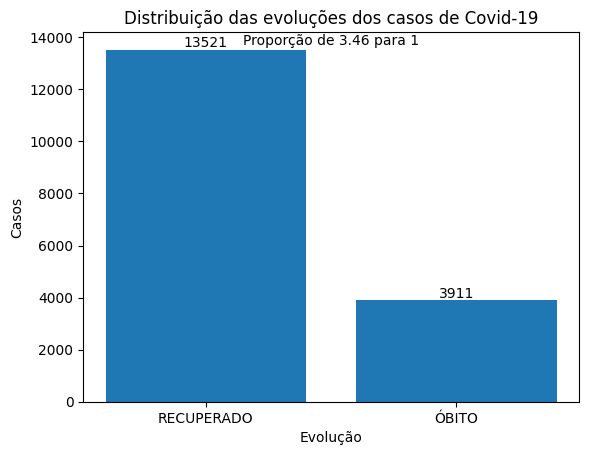

In [ ]:
target_count = data['EVOLUCAO'].value_counts()
recuperado_count = target_count[0]
obito_count = target_count[1]
proportion = round(recuperado_count / obito_count, 2)

# Plotar gráfico de barras
plt.bar(['RECUPERADO', 'ÓBITO'], [recuperado_count, obito_count])
plt.title('Distribuição das evoluções dos casos de Covid-19')
plt.xlabel('Evolução')
plt.ylabel('Casos')

# Adicionar rótulo com a contagem de casos em cada barra
for i, count in enumerate([recuperado_count, obito_count]):
    plt.text(i, count + 100, str(count), ha='center')

# Adicionar rótulo com a proporção
plt.text(0.5, max(recuperado_count, obito_count) + 200, f'Proporção de {proportion} para 1', ha='center')

plt.show()

# Gerando Dataset

In [ ]:
# Criando um novo dataset
#data.to_csv('covid19_PR_2022_NearMiss_S_Norm.csv', index=False)

# Dividindo Dataset

In [ ]:
atributos = data.drop(columns = 'EVOLUCAO')
rotulos = data['EVOLUCAO']

# NearMiss

In [ ]:
np.bincount(rotulos)

array([13521,  3911])

In [ ]:
# instância
nr = NearMiss()

In [ ]:
# Balanceia os dados
atributos, rotulos = nr.fit_resample(atributos, rotulos)

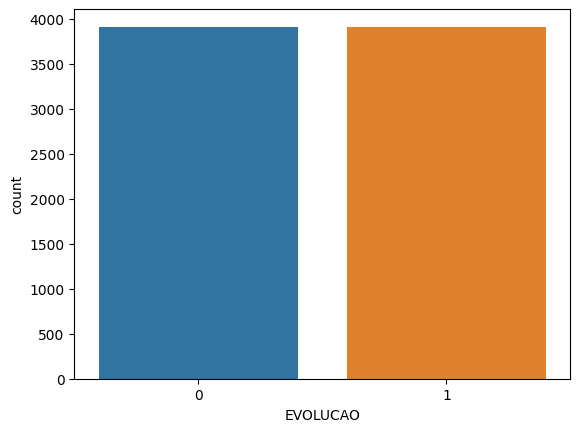

In [ ]:
aux = sns.countplot(x=rotulos)

In [ ]:
# Dividindo o dataset em conjunto de treino e teste
train, test, train_labels, test_labels = train_test_split(
    atributos, rotulos,test_size = 0.33, random_state = 42, stratify=rotulos)

# Classificação

In [ ]:
# Inicializando classificador
ada = AdaBoostClassifier(estimator = LogisticRegression(max_iter=1000), learning_rate = 1.5, n_estimators = 100)

In [ ]:
# treinando
model = ada.fit(train, train_labels)

In [ ]:
# Previsões
preds = ada.predict(test)
preds

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
# Avaliando acurácia
print(accuracy_score(test_labels, preds))

0.7889233152594888


In [ ]:
# F1-score
print(f1_score(test_labels, preds))

0.7871925029285435


In [ ]:
# Analisando
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1291
           1       0.79      0.78      0.79      1291

    accuracy                           0.79      2582
   macro avg       0.79      0.79      0.79      2582
weighted avg       0.79      0.79      0.79      2582



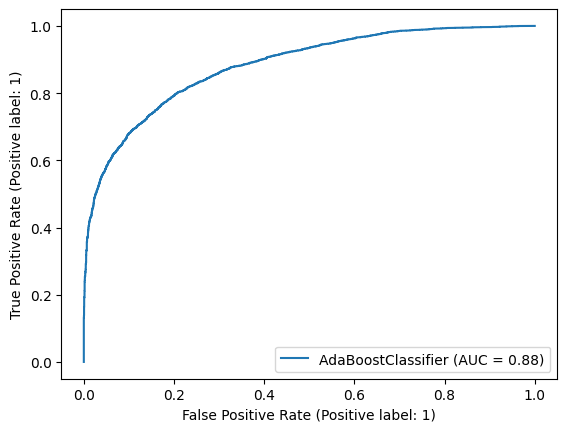

In [ ]:
# Avaliando modelo com valor curva ROC
testeroc = RocCurveDisplay.from_estimator(ada, atributos, rotulos)
plt.show()

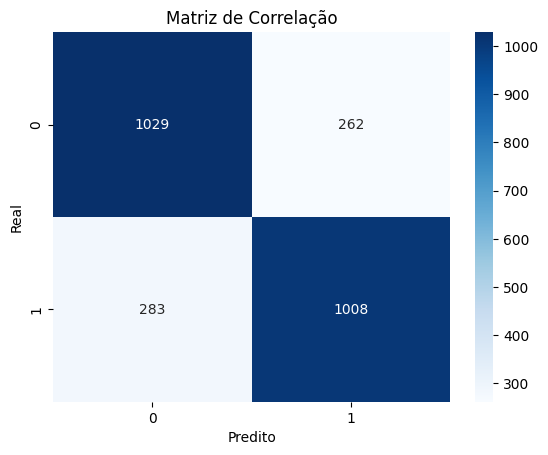

In [ ]:
# Matriz de correlação
matriz_correlacao = pd.crosstab(test_labels, preds, rownames=['Real'],
                                colnames=['Predito'])
# Plotar mapa de calor
sns.heatmap(matriz_correlacao, annot=True, cmap='Blues', fmt='d')
plt.title('Matriz de Correlação')
plt.show()

# GridSearchCV

In [ ]:
'''from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Definir o modelo que deseja otimizar (por exemplo, AdaBoostClassifier)
model = AdaBoostClassifier()

# Definir os parâmetros que deseja otimizar para o modelo
parameters = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.5, 1.0, 1.5],
    'estimator': [DecisionTreeClassifier(), LogisticRegression()],
}

# Criar o objeto GridSearchCV com o modelo e os parâmetros definidos
grid_search = GridSearchCV(model, parameters)

# Executar a busca em grade usando o conjunto de treinamento e etiquetas de treinamento
grid_search.fit(train, train_labels)

# Melhores parâmetros encontrados
best_params = grid_search.best_params_
best_params'''